# Exercise 8

1. Using the EFIplus_medit.zip dataset, Run a simple linear regression relating the species richness with each one of the continuous environmental variables in the dataset: Altitude, Actual_river_slope, Elevation_mean_catch, prec_ann_catch, temp_ann, temp_jan, temp_jul. Before running the analyses, check if any of the variables requires to be transformed and apply the appropriate transformation. Compute the regression coefficient estimates, the r-square and the F-statistics. You may plot the fitted model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.inspection import PartialDependenceDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
df = pd.read_csv('EFIplus_medit.zip',compression='zip', sep=";")
print(df.head())

    Site_code   Latitude  Longitude Country Catchment_name  Galiza  Subsample  \
0  ES_01_0002  38.102003  -4.096070   Spain   Guadalquivir       0          1   
1  ES_02_0001  40.530188  -1.887796   Spain           Tejo       0          1   
2  ES_02_0002  40.595432  -1.928079   Spain           Tejo       0          1   
3  ES_02_0003  40.656184  -1.989831   Spain           Tejo       0          1   
4  ES_02_0004  40.676402  -2.036274   Spain           Tejo       0          1   

   Calib_EFI_Medit  Calib_connect  Calib_hydrol  ...  Squalius malacitanus  \
0                0              1             0  ...                     0   
1                1              1             1  ...                     0   
2                1              1             1  ...                     0   
3                1              1             1  ...                     0   
4                1              1             1  ...                     0   

   Squalius pyrenaicus  Squalius torgalensis

In [3]:
species_columns = df.columns[56:]  

# Criando a coluna de riqueza de espécies (contagem de espécies presentes)
df['species_richness'] = df[species_columns].sum(axis=1)

# Exibe as primeiras linhas para verificar
print(df[['Site_code', 'species_richness']].head())


    Site_code  species_richness
0  ES_01_0002                 1
1  ES_02_0001                 1
2  ES_02_0002                 1
3  ES_02_0003                 2
4  ES_02_0004                 2


In [4]:
vars_to_check = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch',
                 'prec_ann_catch', 'temp_ann']

df_checked = df.copy()

for var in vars_to_check:
    if (df_checked[var] <= 0).any():
        df_checked[var] = df_checked[var] + 0.001

pt = PowerTransformer(method='box-cox', standardize=False)

df_transformed = df.copy()

transformed = pt.fit_transform(df_checked[vars_to_check])
df_transformed[vars_to_check] = transformed

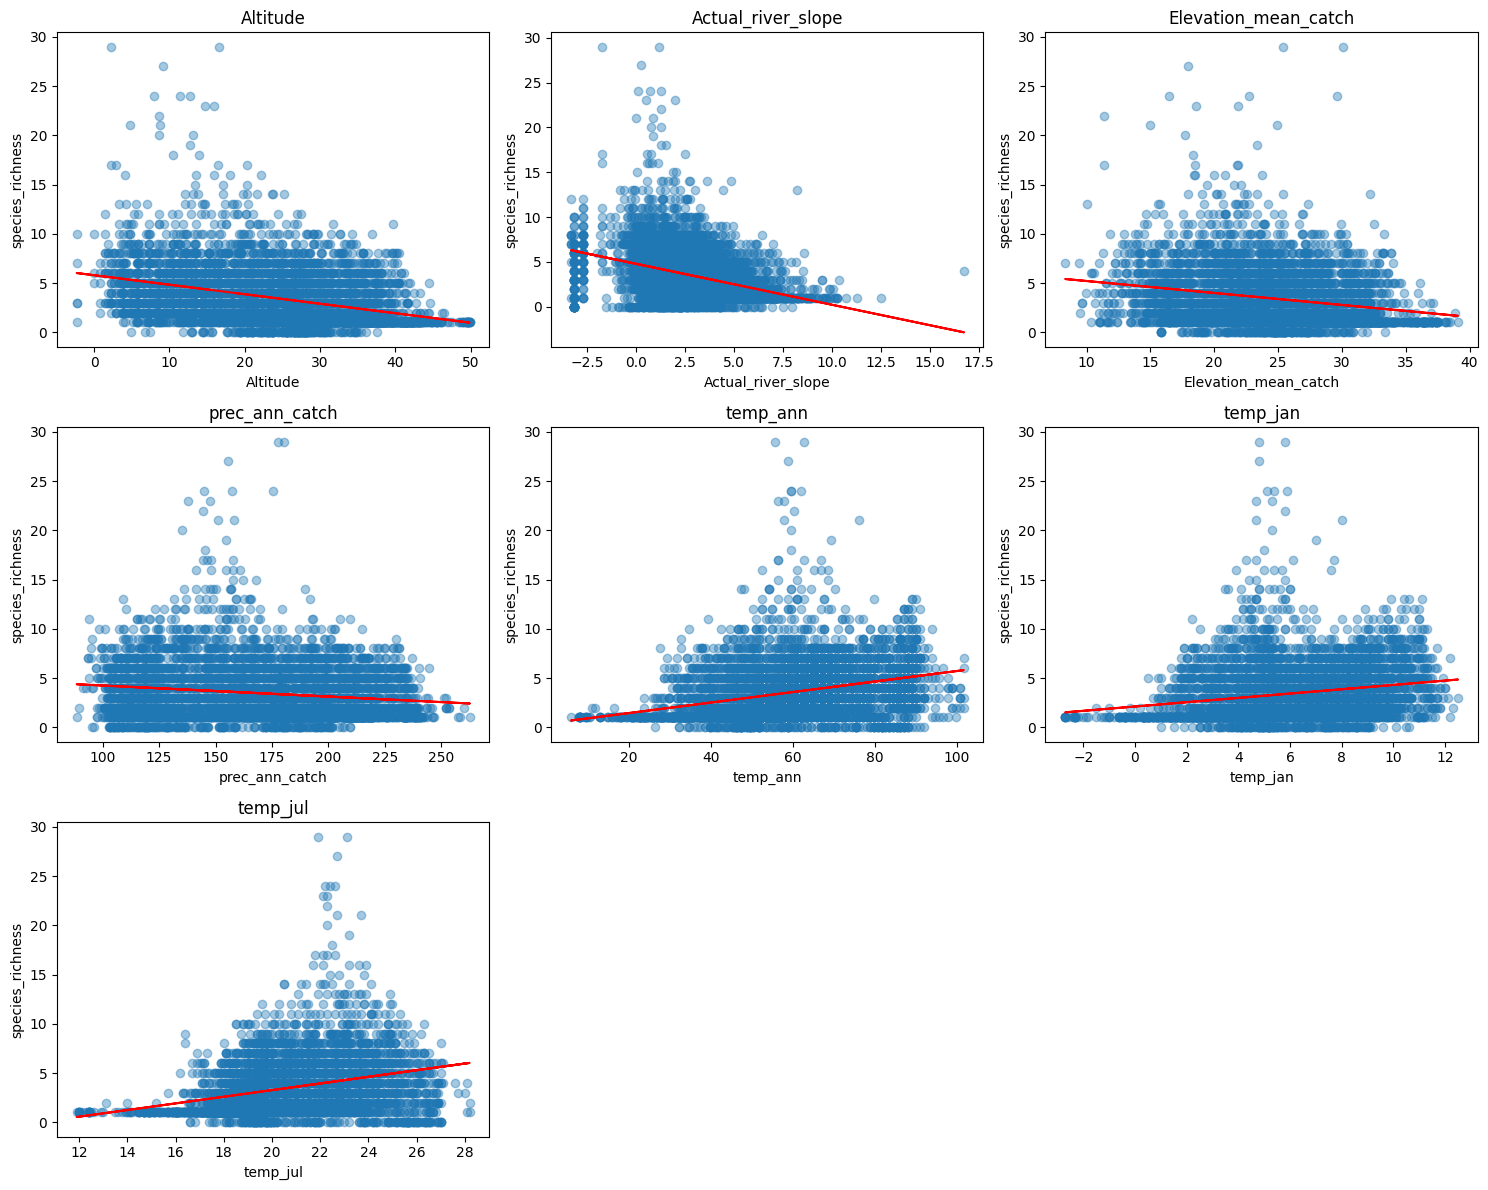

,Variable,Coef,Intercept,R²,F-statistic
0,Altitude,-0.096505,5.795273,0.119166,677.654773
1,Actual_river_slope,-0.455738,4.791524,0.122770,695.977543
2,Elevation_mean_catch,-0.121525,6.422038,0.052205,266.532696
3,prec_ann_catch,-0.011221,5.362701,0.022044,109.076000
4,temp_ann,0.053352,0.379305,0.093751,500.589615
5,temp_jan,0.219182,2.109343,0.041812,211.158516
6,temp_jul,0.336994,-3.472822,0.093046,496.442324


In [5]:
continuous_vars = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch',
                   'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']

results = []
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, var in enumerate(continuous_vars):
    X = df_transformed[[var]].dropna()
    y = df_transformed.loc[X.index, 'species_richness']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)
    n = len(y)
    p = 1
    ssr = np.sum((y_pred - np.mean(y))**2)
    sse = np.sum((y - y_pred)**2)
    msr = ssr / p
    mse = sse / (n - p - 1)
    f_stat = msr / mse

    results.append({
        'Variable': var,
        'Coef': model.coef_[0],
        'Intercept': model.intercept_,
        'R²': r2,
        'F-statistic': f_stat
    })

    ax = axes[idx]
    ax.scatter(X, y, alpha=0.4)
    ax.plot(X, y_pred, color='red')
    ax.set_title(var)
    ax.set_xlabel(var)
    ax.set_ylabel('species_richness')

# Remove empty subplot if fewer than 9 variables
for i in range(len(continuous_vars), 9):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

pd.DataFrame(results)


2. Now try to run a multiple linear regression with the same data and check the differences between the 
previous univariate regression coefficients and the new coefficients. Plot the partial dependence plots 
to compare responses with the previous single effects.

In [6]:
data = df_transformed[continuous_vars + ['species_richness']].dropna()
X = data[continuous_vars]
y = data['species_richness']

model_multi = LinearRegression()
model_multi.fit(X, y)

multi_coefs = pd.DataFrame({
    'Variable': continuous_vars,
    'Multiple_Coef': model_multi.coef_
})

In [7]:
uni_df = pd.DataFrame(results)  # results vem do passo anterior
comparison = uni_df.merge(multi_coefs, on='Variable')
print(comparison)

               Variable      Coef  Intercept        R²  F-statistic  \
0              Altitude -0.096505   5.795273  0.119166   677.654773   
1    Actual_river_slope -0.455738   4.791524  0.122770   695.977543   
2  Elevation_mean_catch -0.121525   6.422038  0.052205   266.532696   
3        prec_ann_catch -0.011221   5.362701  0.022044   109.076000   
4              temp_ann  0.053352   0.379305  0.093751   500.589615   
5              temp_jan  0.219182   2.109343  0.041812   211.158516   
6              temp_jul  0.336994  -3.472822  0.093046   496.442324   

   Multiple_Coef  
0      -0.186063  
1      -0.284086  
2      -0.032092  
3       0.005461  
4      -0.024351  
5      -0.573403  
6       0.412598  


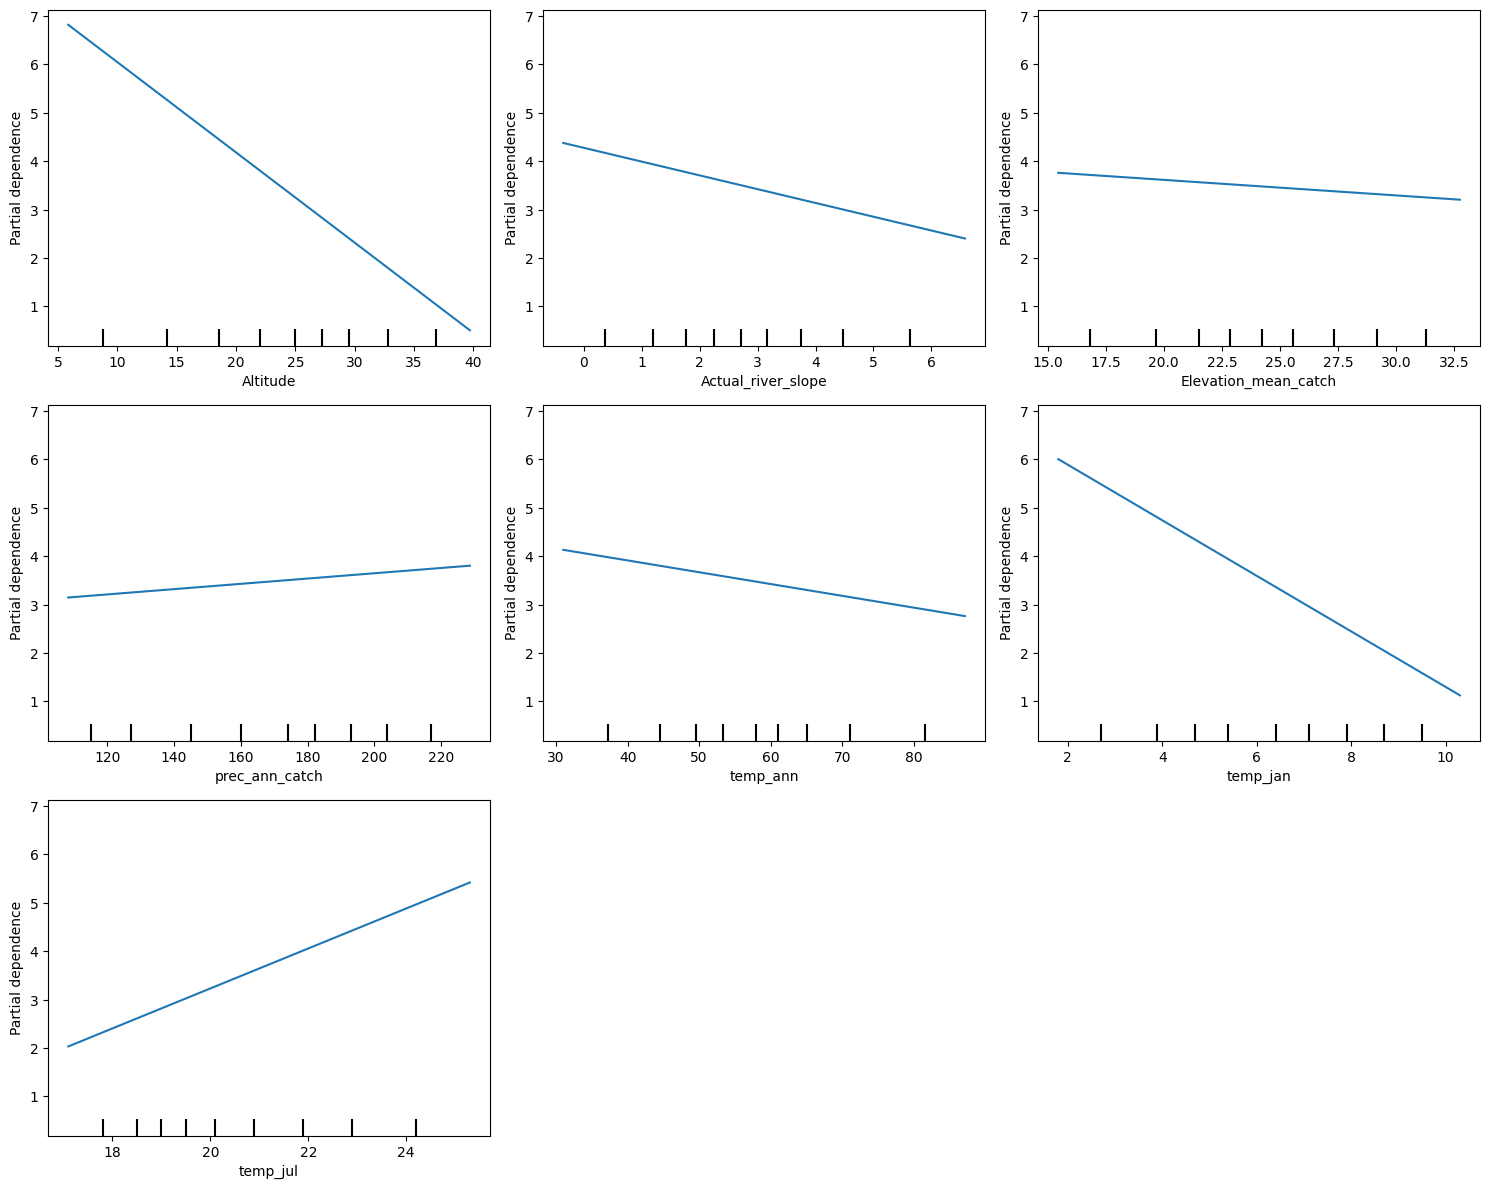

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
axes = ax.flatten()

PartialDependenceDisplay.from_estimator(model_multi, X, continuous_vars, ax=axes[:7])

for i in range(7, 9):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

3. Check the multicolinearity among the predictor variables and run a second more parsimonious 
regression model. Check how the coefficients have changed.

In [9]:
# Preparar os dados para o cálculo do VIF
X_vif = df_transformed[continuous_vars].dropna()

# Adicionar uma constante para calcular o VIF
X_vif = add_constant(X_vif)

# Calcular o VIF para cada variável
vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Exibir os VIFs
print(vif_data)

# Identificar variáveis com VIF alto (> 10) para eliminar
high_vif_vars = vif_data[vif_data['VIF'] > 10]['Variable'].tolist()
high_vif_vars.remove('const')  # Remover a constante da lista de variáveis com VIF alto
print(f"Variáveis com alto VIF: {high_vif_vars}\n")

# Criar um modelo mais simples, removendo variáveis com VIF alto
X_simple = df_transformed[continuous_vars].dropna()
X_simple = X_simple.drop(columns=high_vif_vars)
y_simple = df_transformed.loc[X_simple.index, 'species_richness']

# Ajustar o modelo de regressão múltipla
model_simple = LinearRegression()
model_simple.fit(X_simple, y_simple)

# Coeficientes do modelo simples
simple_coefs = pd.DataFrame({
    'Variable': X_simple.columns,
    'Coef (Simple Model)': model_simple.coef_
})

# Coeficientes do modelo completo (anterior)
model_full = LinearRegression()
model_full.fit(df_transformed[continuous_vars].dropna(), df_transformed.loc[X_simple.index, 'species_richness'])

full_coefs = pd.DataFrame({
    'Variable': continuous_vars,
    'Coef (Full Model)': model_full.coef_
})

# Comparar coeficientes
comparison_coefs = pd.merge(full_coefs, simple_coefs, on='Variable', how='outer')
print(comparison_coefs)

               Variable         VIF
0                 const  594.238651
1              Altitude    5.728625
2    Actual_river_slope    1.259956
3  Elevation_mean_catch    4.772608
4        prec_ann_catch    2.488525
5              temp_ann   42.350675
6              temp_jan   21.274470
7              temp_jul   14.075573
Variáveis com alto VIF: ['temp_ann', 'temp_jan', 'temp_jul']

               Variable  Coef (Full Model)  Coef (Simple Model)
0    Actual_river_slope          -0.284086            -0.307544
1              Altitude          -0.186063            -0.120871
2  Elevation_mean_catch          -0.032092             0.103366
3        prec_ann_catch           0.005461            -0.009224
4              temp_ann          -0.024351                  NaN
5              temp_jan          -0.573403                  NaN
6              temp_jul           0.412598                  NaN


In [10]:
X_full = df_transformed[continuous_vars].dropna()
y_full = df_transformed.loc[X_full.index, 'species_richness']

X_full_const = sm.add_constant(X_full)
model_full = sm.OLS(y_full, X_full_const).fit()


X_pars = df_transformed[X_simple.columns].dropna()
y_pars = df_transformed.loc[X_pars.index, 'species_richness']

X_pars_const = sm.add_constant(X_pars)
model_pars = sm.OLS(y_pars, X_pars_const).fit()


print("Modelo Completo:")
print(f"  R2: {model_full.rsquared:.4f}")
print(f"  R2 Ajustado: {model_full.rsquared_adj:.4f}")

print("\nModelo Parcimonioso:")
print(f"  R2: {model_pars.rsquared:.4f}")
print(f"  R2 Ajustado: {model_pars.rsquared_adj:.4f}")

Modelo Completo:
  R2: 0.2622
  R2 Ajustado: 0.2612

Modelo Parcimonioso:
  R2: 0.2005
  R2 Ajustado: 0.1998
